In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import os
import math

In [10]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size 
batch_size = 64

# Layer adapt
ksize = 4 # Kernel size : was '4' for 64x64 image
ssize = 2 # Stride size : was '2' for 64x64 image

# Size of test set (in %)
testsize = 0.3

# Number of epochs in model
epoch_t = 40

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

In [11]:
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


**Create new directory for version**

In [12]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/DenseNet"
    for files in os.listdir(dir):
        if "DenseNet" in files: 
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: DenseNet-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v{new_vnum:03}"
    os.makedirs(new_dir)

14 matches(es) found
--------------
New folder name: DenseNet-local-v016
--------------


# Data

In [13]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    path_gen_images = "/kaggle/input//cganlocalv007/cgan-local-v007"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = "/kaggle/input/checkpoints" 

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    path_gen_images = "C:/Users/Max/Documents/image_data/cgan-local-v007"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = 'C:/Users/Max/Documents/GitHub/dcgan_kaggle_output/dcgan-kaggle-v002/checkpoints'
    

In [14]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

In [15]:
batches = ImageDataGenerator().flow_from_directory(
    directory  = path_root, 
    color_mode = ch, 
    target_size= (ih,iw), 
    interpolation="bicubic",
    class_mode = 'sparse',
    batch_size=40000
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [16]:
imgs = tf.keras.applications.densenet.preprocess_input(imgs)
labels = np.array(labels)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=testsize)

In [18]:
X_train_size = len(X_train)
X_test_size = len(X_test)

print(f"Size of training data: {X_train_size} | Shape of training data {X_train.shape}")
print(f"Size of training data: {X_test_size}  | Shape of training data {X_test.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 18583 | Shape of training data (18583, 64, 64, 3)
Size of training data: 7965  | Shape of training data (7965, 64, 64, 3)
Shape of training labels (18583,)
Shape of training labels (7965,)


In [19]:
batches.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9,
 'benign': 10}

# DenseNet

In [20]:
head_model = load_model("C:/Users/Max/Documents/GitHub/DenseNet/DenseNet-cgan-kaggle-v014/model.h5")

In [21]:
scores = head_model.evaluate(X_test, y_test)
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

249/249 [==============================] - 11s 31ms/step - loss: 0.0800 - accuracy: 0.9759
Overall CNN Accuracy: 0.9758945107460022
(The number of correct predictions divided by the number of total predictions)


# Plots

In [22]:
multi_distribution = np.unique(y_train, return_counts=True)

In [23]:
classes = batches.class_indices.keys()

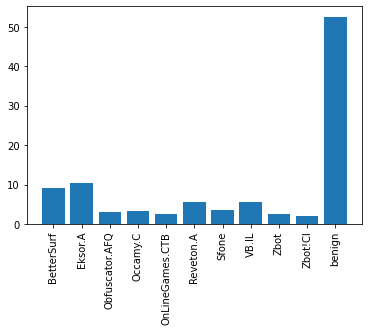

In [24]:
perc = (multi_distribution[1]/y_train.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"C:/Users/Max/Documents/GitHub/DenseNet/DenseNet-cgan-kaggle-v009/multi_data_dist.png", bbox_inches = 'tight')

In [25]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = X_train_size + X_test_size

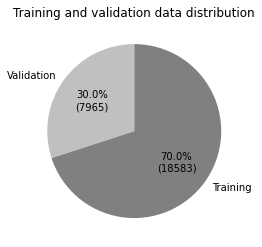

In [26]:
plt.pie(
    [X_train_size, X_test_size], 
    labels = ["Training", "Validation"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['gray', 'silver']
)

plt.title("Training and validation data distribution")

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight')

# Analyse performance

**Multiclass classification**

In [28]:
from sklearn import metrics
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

Multiclass performance table

In [29]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1],4)])
t.add_row(['Validation loss', round(scores[0],4)])
t.header = True
t.align = "l"
t.title = "Perf. of multi-class classification - DenseNet"
print(t)

+------------------------------------------------+
| Perf. of multi-class classification - DenseNet |
+------------------------------+-----------------+
| Metric                       | Performance     |
+------------------------------+-----------------+
| Valididation accuracy        | 0.9759          |
| Validation loss              | 0.08            |
+------------------------------+-----------------+


In [30]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

In [31]:
y_pred = np.argmax(head_model.predict(X_test), axis=-1)

In [32]:
y_pred

array([ 1,  7, 10, ..., 10,  1, 10], dtype=int64)

In [33]:
y_test2 = y_test
y_test2

array([ 1.,  7., 10., ..., 10.,  1., 10.], dtype=float32)

In [34]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [35]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png")

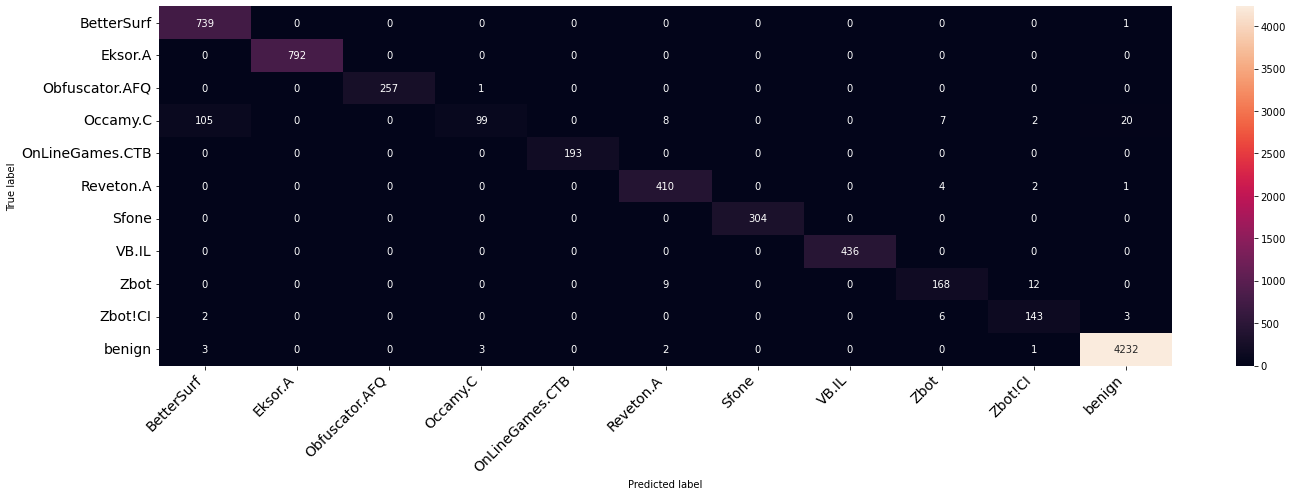

In [36]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

**Binary classification**


In [37]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
if len(y_truebin) == len(y_predbin):
    print(f"Length of the observations in test set: {len(y_truebin)}")

Length of the observations in test set: 7965


In [38]:
rw_count = 0
bn_count = 0
for count, value in enumerate(multi_distribution[1]):
    if count in range(10):
        rw_count = rw_count + multi_distribution[1][count]
    else: 
        bn_count = bn_count + multi_distribution[1][count]
print(f"Ransomware Occurences: {rw_count}, Benign Occurences: {bn_count}")

Ransomware Occurences: 8812, Benign Occurences: 9771


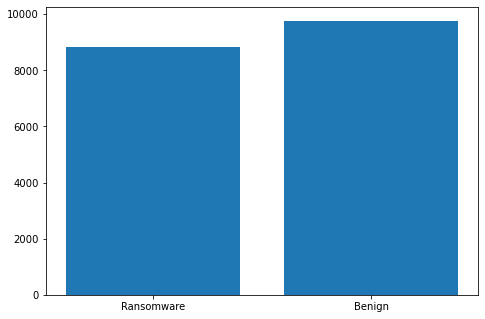

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count, bn_count]
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("data_dist.png.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight')

In [40]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [41]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("DenseNet121")
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png", bbox_inches = 'tight')

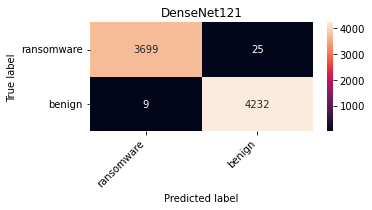

In [42]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [43]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [44]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [45]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [46]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

In [47]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of DenseNet"
print(t)

+------------------------------------------------+
|            Performance of DenseNet             |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.9933      |
| Accuracy                         | 0.9957      |
| F1 Score                         | 0.996       |
| Matthews Correlation Coefficient | 0.9914      |
+----------------------------------+-------------+


In [48]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)